installazione delle dipendenze necessarie

In [1]:
!pip install transformers sentence-transformers pgvector psycopg2


  Using cached pgvector-0.3.6-py3-none-any.whl.metadata (13 kB)
  Using cached psycopg2-2.9.10-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
  Using cached numpy-2.1.2-cp312-cp312-win_amd64.whl.metadata (59 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached regex-2024.9.11-cp312-cp312-win_amd64.whl.metadata (41 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached safetensors-0.4.5-cp312-none-win_amd64.whl.metadata (3.9 kB)
  Using cached tokenizers-0.20.1-cp312-none-win_amd64.whl.metadata (6.9 kB)
  Using cached tqdm-4.66.6-py3-none-any.whl.metadata (57 kB)
  Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl.metadata (13 kB)
  Using cached scipy-1.14.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached pillow-11.0.0-cp312-cp312-win_amd64.whl.metadata (9.3 kB)
  Using


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from sentence_transformers import SentenceTransformer
import psycopg2




C:\Users\Francesco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Caricamento del DB using Pyscopg2

In [3]:
# Connessione al database
conn = psycopg2.connect(
    dbname="TestDbForS&A",
    user="postgres",
    password="578366",
    host="localhost"
)
cur = conn.cursor()


In [4]:
cur.close()
conn.close()

In [17]:
cur.execute("""
        INSERT INTO joined_data (id, sender_id, receiver_id, exchange_type, data_size_mb, exchange_properties,
                                 sender_name, sender_label, sender_properties, receiver_name, receiver_label, receiver_properties)
        SELECT de.id, de.sender_id, de.receiver_id, de.exchange_type, de.data_size_mb, de.properties AS exchange_properties,
               es.name AS sender_name, es.custom_label AS sender_label, es.properties AS sender_properties,
               er.name AS receiver_name, er.custom_label AS receiver_label, er.properties AS receiver_properties
        FROM data_exchange de
        JOIN entities es ON de.sender_id = es.id
        JOIN entities er ON de.receiver_id = er.id
        WHERE de.id NOT IN (SELECT id FROM joined_data)
    """)

conn.commit()


Generazione degli embedding e successiva memorizzazione.

In [18]:
'''Altera entities table con la collonna degli embedding'''


cur.execute("CREATE EXTENSION IF NOT EXISTS vector")

cur.execute("ALTER TABLE joined_data ADD COLUMN embedding vector(768)")

In [19]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Inizializza il modello di embedding
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')



def parse_entity_properties(properties):
    """
    Extract useful values from the JSON properties.
    Ignore property names and other irrelevant characters.
    """
    parsed_data = []
    
    # Iterate through the properties and collect only the useful values
    for property_value in properties.items():
        # If the value is a dictionary, extract the 'value' field
        if isinstance(property_value, dict) and 'value' in property_value:
            value = property_value['value']
        else:
            value = str(property_value)
        
        # Append the cleaned value to the list
        parsed_data.append(value)
    
    # Concatenate all values into a single string separated by spaces
    return ' '.join(parsed_data)


def fetch_joined_data():
    """
    Fetch data from the joined_data table.
    """
    cur.execute("""
        SELECT id, sender_name, sender_label, receiver_name, receiver_label, exchange_type, data_size_mb, exchange_properties, sender_properties, receiver_properties
        FROM joined_data
    """)
    return cur.fetchall()

def prepare_embeddings(joined_data):
    
    embeddings_list = []
    entity_ids = []
    names = []

    for data in joined_data:
        try:
            # Concatenate the fields for embedding generation
            entity_text = f"{data[1]} {data[2]} {data[3]} {data[4]} {data[5]} {data[6]} {parse_entity_properties(data[7])} {parse_entity_properties(data[8])} {parse_entity_properties(data[9])}"
            
            
            # Generate the embedding for the constructed entity text
            entity_embedding = model.encode(entity_text)

            # Add the generated embedding and entity ID to the lists
            embeddings_list.append(entity_embedding)
            entity_ids.append(data[0])  # Add entity ID to list

        except Exception as e:
            print(f"Error processing entity {data[0]}: {e}")
    
    return np.array(embeddings_list, dtype=np.float32), entity_ids



In [20]:
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss

# Initialize the embedding model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')



def create_faiss_index(embeddings_list, embedding_dim):
    """
    Create a FAISS index and add embeddings to it.
    """
    index = faiss.IndexFlatL2(embedding_dim)
    embedding_matrix = np.array(embeddings_list, dtype=np.float32)
    index.add(embedding_matrix)
    return index

def query_similar_entities(query_text, index, entity_ids, top_k=3):
    """
    Query the FAISS index for the most similar entities.
    """
    query_embedding = model.encode(query_text)
    D, I = index.search(np.array([query_embedding], dtype=np.float32), top_k)
    results = [(entity_ids[idx], D[0][i]) for i, idx in enumerate(I[0])]
    print("Top similar entities:")
    for result in results:
        print(f"Entity ID: {result[0]}, Similarity Score: {result[1]}")
    return results


In [22]:
joined_data = fetch_joined_data()

embeddings_list, entity_ids = prepare_embeddings(joined_data)

len(embeddings_list)

index = create_faiss_index(embeddings_list, 768)

query_similar_entities("Interazioni che comprendono connessioni telefoniche con Mbps di 300 o piu ", index, entity_ids)

Giulia Verdi PersonaFisica Luca Bianchi PersonaFisica internet 300 ('Protocol', 'IPv4') ('SpeedMbps', 20) ('ConnectionType', 'ADSL') ('Email', {'value': 'giulia.verdi@example.com'}) ('IPAddress', {'value': '2001:db8::ff00:42:8329'}) ('PhoneNumber', {'value': '+393334444444'}) ('Email', {'value': 'luca.bianchi@example.com'}) ('IPAddress', {'value': '172.16.0.2'}) ('PhoneNumber', {'value': '+393331111111'})
Tech Solutions SRL Organization Azienda Logistica ABC Logistics internet 800 ('Protocol', 'IPv6') ('SpeedMbps', 500) ('ConnectionType', 'Fiber') ('Role', {'value': 'IT Consulting'}) ('Localita', {'value': 'Torino'}) ('Descrizione', {'value': 'Tech Solutions SRL'}) ('Role', {'value': 'Supply Chain'}) ('Descrizione', {'value': 'Azienda Logistica ABC'}) ('Headquarters', {'value': 'Bologna'})
Francesca Neri PersonaFisica Gruppo Sicurezza Omega Security cellular 100 ('Protocol', 'IPv6') ('SpeedMbps', 2000) ('ConnectionType', '5G') ('Email', {'value': 'francesca.neri@example.com'}) ('IPAddr

[(9, 1.1007217), (12, 1.1007907), (14, 1.1149526)]

Visualizzazione 3d degli embedding in 3D usando t-SNE.

Top similar entities:
Entity ID: 6, Similarity Score: 0.8547351360321045
Entity ID: 3, Similarity Score: 0.8956740498542786
Entity ID: 13, Similarity Score: 0.9391774535179138


<Figure size 1000x800 with 0 Axes>

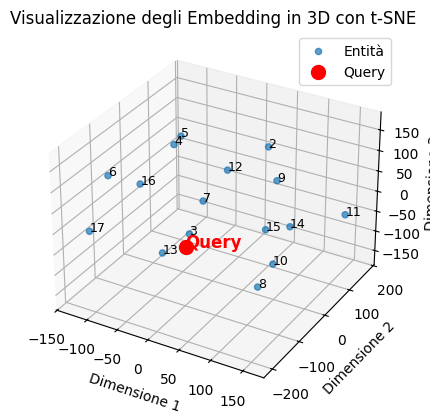

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def generate_embedding_rappresentation(embeddings, query_embedding, names, dim=2):
    # Aggiungi l'embedding della query e il nome "Query"
    all_embeddings = np.vstack([embeddings, query_embedding])
    all_names = names + ["Query"]

    # Esegui t-SNE per ridurre a 2 o 3 dimensioni
    tsne = TSNE(n_components=dim, perplexity=min(30, len(all_embeddings)-1), random_state=42)
    embeddings_tsne = tsne.fit_transform(all_embeddings)
    
    # Separa gli embeddings delle entità da quello della query
    entity_embeddings_tsne = embeddings_tsne[:-1]  # tutti tranne l'ultimo
    query_embedding_tsne = embeddings_tsne[-1]     # l'ultimo (la query)

    # Crea il grafico
    plt.figure(figsize=(10, 8))

    if dim == 2:
        # Scatter plot per gli embeddings delle entità
        plt.scatter(entity_embeddings_tsne[:, 0], entity_embeddings_tsne[:, 1], alpha=0.7, label="Entità")
        
        # Scatter plot per l'embedding della query (in rosso)
        plt.scatter(query_embedding_tsne[0], query_embedding_tsne[1], color='red', label="Query", s=100)

        # Aggiungi i nomi delle entità come etichette
        for i, name in enumerate(names):
            plt.text(entity_embeddings_tsne[i, 0], entity_embeddings_tsne[i, 1], name, fontsize=9)
        
        # Aggiungi il nome "Query" per la query
        plt.text(query_embedding_tsne[0], query_embedding_tsne[1], "Query", fontsize=12, color='red', fontweight='bold')

        plt.title('Visualizzazione degli Embedding in 2D con t-SNE')
        plt.xlabel('Dimensione 1')
        plt.ylabel('Dimensione 2')
    elif dim == 3:
        ax = plt.figure().add_subplot(projection='3d')
        # Scatter plot per gli embeddings delle entità
        ax.scatter(entity_embeddings_tsne[:, 0], entity_embeddings_tsne[:, 1], entity_embeddings_tsne[:, 2], alpha=0.7, label="Entità")
        
        # Scatter plot per l'embedding della query (in rosso)
        ax.scatter(query_embedding_tsne[0], query_embedding_tsne[1], query_embedding_tsne[2], color='red', label="Query", s=100)

        # Aggiungi i nomi delle entità come etichette
        for i, name in enumerate(names):
            ax.text(entity_embeddings_tsne[i, 0], entity_embeddings_tsne[i, 1], entity_embeddings_tsne[i, 2], name, fontsize=9)

        ax.text(query_embedding_tsne[0], query_embedding_tsne[1], query_embedding_tsne[2], "Query", fontsize=12, color='red', fontweight='bold')

        plt.title('Visualizzazione degli Embedding in 3D con t-SNE')
        ax.set_xlabel('Dimensione 1')
        ax.set_ylabel('Dimensione 2')
        ax.set_zlabel('Dimensione 3')

    plt.legend()
    plt.show()

# Esempio di utilizzo
query_text = "Compagnie che usano indirizzi internet"
query_similar_entities(query_text, index, entity_ids)
generate_embedding_rappresentation(embeddings_list,  model.encode(query_text), entity_ids, dim=3)  # Per visualizzazione 2D

Implementazione ricerca utilizzando un LLM per generare una query a partire da linguaggio naturale.

postgresql


In [ ]:
from langchain_experimental.sql.base import SQLDatabaseSequentialChain
from langchain_ollama.llms import OllamaLLM
from langchain.llms import GPT4All




'''
model = GPT4All(model="D:\GPTForAll\models\Llama-3.2-3B-Instruct-Q4_0.gguf")
model = OllamaLLM(model="llama3.1",base_url="http://192.168.100.149:8537")
'''


model = OllamaLLM(model="llama3.1",base_url="http://192.168.0.212:11434")

# Inizializza la catena SQL usando from_llm
db_chain = SQLDatabaseSequentialChain.from_llm(llm=model, db=db, verbose=True)

# Query SQL
query = "Delete from data_exchange where id = 10"

# Esegui la query
response = db_chain.invoke(query)
print(response)


<>:7: SyntaxWarning: invalid escape sequence '\G'
<>:7: SyntaxWarning: invalid escape sequence '\G'
C:\Users\Francesco\AppData\Local\Temp\ipykernel_36172\1339438886.py:7: SyntaxWarning: invalid escape sequence '\G'
  model = GPT4All(model="D:\GPTForAll\models\Llama-3.2-3B-Instruct-Q4_0.gguf")




> Entering new SQLDatabaseChain chain...
Dalla tabbella joined_data dimmi se Giulia Verdi ha interagito con Luca Bianchi 
SQLQuery:

Exception ignored on calling ctypes callback function: <function LLModel._prompt_callback at 0x0000016E300823E0>
Traceback (most recent call last):
  File "C:\Users\Francesco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gpt4all\_pyllmodel.py", line 614, in _prompt_callback
    @staticmethod

KeyboardInterrupt: 


In [106]:
from transformers import RagTokenizer, RagSequenceForGeneration, pipeline


# Carica il modello RAG "facebook/rag-sequence-nq"
tokenizer = RagTokenizer.from_pretrained("facebook/rag-sequence-nq")
model = RagSequenceForGeneration.from_pretrained("facebook/rag-sequence-nq")

# Inizializza il pipeline RAG
rag_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Funzione per generare risposte basate su RAG
def generate_answer_based_on_retrieval(query_text, top_k=1):
    # Prima recupera le entità simili
    similar_entities = query_similar_entities(query_text, top_k=top_k)

    # Verifica che ci siano entità simili trovate
    if not similar_entities:
        print("Nessuna entità simile trovata.")
        return

    context = "".join(
        f"Name: {entity[1]}, Label: {entity[2]}, Info: {entity[3]}\n"
        for entity in similar_entities
    )
    # Poi genera la risposta basata sui dati
    question = query_text
    input_text = f"question: {question} context: {context}"

    # Genera la risposta
    answer = rag_pipeline(input_text, max_length=100, num_return_sequences=1)

    # Stampa il risultato
    print(f"Query: {query_text}")
    print(f"Context:\n{context}")
    print(f"Answer: {answer[0]['generated_text']}")

# Esempio di domanda
generate_answer_based_on_retrieval("Quali aziende hanno usato connessioni IPv6?")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

AttributeError: 'RagTokenizer' object has no attribute 'pad_token_id'

In [ ]:
from numba import jit
import numpy as np



@jit(nopython=True)
def cosine_similarity(A, B):
    dot_product = 0.0
    norm_A = 0.0
    norm_B = 0.0
    
    for i in range(len(A)):
        dot_product += A[i] * B[i]
        norm_A += A[i] * A[i]
        norm_B += B[i] * B[i]
    
    return dot_product / (np.sqrt(norm_A) * np.sqrt(norm_B))

In [65]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ruptures as rpt

text = """Artificial intelligence is rapidly transforming many industries, from healthcare to finance. Through advanced algorithms and the use of machine learning models, it is possible to analyze massive amounts of data and generate accurate predictions. For example, in the healthcare sector, AI can help diagnose diseases more quickly and efficiently. Personalizing treatments is another benefit of the technology, allowing doctors to tailor therapies to each patient's specific profile. This technological development, however, also raises significant ethical concerns, such as data privacy and the risk of fully automated decision-making.

On the other hand, the growth of renewable energy is paving new paths toward a more sustainable future. Solar, wind, and hydroelectric power represent clean alternatives to fossil fuels. With the increasing efficiency of solar panels and wind turbines, more nations are investing in these technologies to reduce reliance on traditional fuels. However, the transition to clean energy also poses logistical and infrastructure challenges, such as storage and distribution of the generated power. In the long term, these advancements could lessen environmental impact and help slow climate change."""



# Inizializza il modello di embedding
model = SentenceTransformer('all-MiniLM-L6-v2')

# Divide il testo in frasi
sentences = text.split('. ')

# Calcola gli embeddings per ogni frase
embeddings = [model.encode(sentence) for sentence in sentences]

# Calcola la similarità coseno tra embeddings consecutivi
# La dissimilarità è calcolata come (1 - similarità coseno)
similarities = cosine_similarity(embeddings)
dissimilarities = np.array([1 - similarities[i, i + 1] for i in range(len(embeddings) - 1)])

# Usa ruptures per trovare i punti di cambiamento
algo = rpt.Pelt(model="rbf").fit(dissimilarities)
change_points = algo.predict(pen=0.1)  # Regola il valore di penalizzazione

# Segmenta il testo in chunk tematici
chunks = []
start = 0
for cp in change_points:
    chunk = ". ".join(sentences[start:cp])
    chunks.append(chunk)
    start = cp

# Stampa i chunk individuati
for idx, chunk in enumerate(chunks):
    print(f"Chunk {idx + 1}:\n{chunk}\n")


Chunk 1:
Artificial intelligence is rapidly transforming many industries, from healthcare to finance. Through advanced algorithms and the use of machine learning models, it is possible to analyze massive amounts of data and generate accurate predictions. For example, in the healthcare sector, AI can help diagnose diseases more quickly and efficiently. Personalizing treatments is another benefit of the technology, allowing doctors to tailor therapies to each patient's specific profile. This technological development, however, also raises significant ethical concerns, such as data privacy and the risk of fully automated decision-making.

On the other hand, the growth of renewable energy is paving new paths toward a more sustainable future

Chunk 2:
Solar, wind, and hydroelectric power represent clean alternatives to fossil fuels. With the increasing efficiency of solar panels and wind turbines, more nations are investing in these technologies to reduce reliance on traditional fuels. Howe

In [96]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ruptures as rpt

# Initialize the embedding model
model = SentenceTransformer("jinaai/jina-embeddings-v2-base-en")

# Sample text
text = """Artificial intelligence is transforming industries across the world, with applications in healthcare, finance, and beyond. 
In healthcare, AI algorithms assist in diagnosing diseases more accurately and provide predictive analytics for patient outcomes. 
Machine learning models analyze medical records, imaging data, and even genetic information to offer insights that were previously inaccessible. 
Another major benefit is the potential for personalized medicine, where AI tailors treatments to the individual characteristics of each patient, 
improving recovery rates and minimizing side effects. However, the rise of AI in healthcare also brings challenges around data privacy and the ethics 
of automated decision-making, as well as concerns about the potential biases embedded in AI models, which could lead to unfair treatment recommendations.

On the other hand, renewable energy has seen exponential growth in recent years, driven by the need to reduce reliance on fossil fuels and mitigate climate change. 
Solar energy is becoming more efficient and cost-effective, with large-scale installations providing power to millions of homes. Wind energy has similarly advanced, 
with new turbine designs capable of generating electricity even in low-wind conditions. Hydroelectric power continues to be a reliable source of clean energy, 
with innovations that minimize environmental impact. As nations seek to meet ambitious carbon reduction targets, renewable energy is at the forefront of policy initiatives."""


# Split text into sentences
sentences = text.split('.')

# Compute embeddings for each sentence
embeddings = [model.encode(sentence) for sentence in sentences]

# Calculate cosine similarity between consecutive embeddings and dissimilarity as 1 - similarity
similarities = cosine_similarity(embeddings)
dissimilarities = [1 - similarities[i, i + 1] for i in range(len(embeddings) - 1)]

# Use ruptures to detect change points in dissimilarities
algo = rpt.Pelt(model="rbf").fit(np.array(dissimilarities))
change_points = algo.predict(pen=0.2)  # Adjust penalty for sensitivity

# Segment text into thematic chunks based on change points
chunks = []
start = 0
for cp in change_points:
    chunk = ". ".join(sentences[start:cp])
    chunks.append(chunk)
    start = cp

# Output the detected chunks
for idx, chunk in enumerate(chunks):
    print(f"Chunk {idx + 1}:\n{chunk}\n")

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

Chunk 1:
Artificial intelligence is transforming industries across the world, with applications in healthcare, finance, and beyond.  
In healthcare, AI algorithms assist in diagnosing diseases more accurately and provide predictive analytics for patient outcomes.  
Machine learning models analyze medical records, imaging data, and even genetic information to offer insights that were previously inaccessible.  
Another major benefit is the potential for personalized medicine, where AI tailors treatments to the individual characteristics of each patient, 
improving recovery rates and minimizing side effects.  However, the rise of AI in healthcare also brings challenges around data privacy and the ethics 
of automated decision-making, as well as concerns about the potential biases embedded in AI models, which could lead to unfair treatment recommendations

Chunk 2:


On the other hand, renewable energy has seen exponential growth in recent years, driven by the need to reduce reliance on fo

In [104]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ruptures as rpt

# Initialize the embedding model
model = SentenceTransformer('nickprock/sentence-bert-base-italian-uncased')

# Sample text
text = """Il protagonista è un giovane uomo il cui vero nome non viene mai menzionato esplicitamente. Lavora come consulente nel ramo assicurativo di un'importante casa automobilistica. Si tratta dello stereotipo del cittadino medio: frustrato dal lavoro, schiavo del consumismo, depresso, insonne, ansioso e stordito dal jet lag. La sua unica forma di felicità e svago è l'arredare il suo appartamento, nel quale vive da solo. L'uomo trova un'apparente cura ai suoi problemi cominciando a frequentare, mentendo sulle sue reali condizioni di salute, gruppi d'ascolto per persone affette da mali incurabili; in questo modo incontra anche Marla Singer, una giovane donna depressa che, come lui, finge di avere gravi malattie per poter frequentare i gruppi. Dato che l'uomo non riesce a essere tranquillo sapendo di avere un'altra bugiarda nei suoi stessi gruppi, le propone di dividersi le frequentazioni a settimane alterne, e i due si scambiano i numeri di telefono.

Durante uno dei suoi viaggi di lavoro, il protagonista conosce Tyler Durden, un eccentrico produttore e venditore di saponette, che abita nella sua stessa città. Quello stesso giorno, tornato dal lavoro, il protagonista scopre che la propria abitazione, insieme a tutti i suoi preziosi mobili, è andata distrutta in un'esplosione causata da una perdita di gas. Disperato e affidandosi al caso, telefona a Tyler e decide di incontrarlo nuovamente. Dopo aver passato la serata in un locale, decidono di picchiarsi per sfogare le proprie frustrazioni, e in seguito Tyler lo ospita nella propria fatiscente abitazione. Tra i due nascerà un affiatato quanto bizzarro rapporto, nel quale il protagonista si farà sempre trasportare di più dalla filosofia anarchica e libera da qualunque vincolo di Tyler, lasciando il lavoro e i gruppi, rubando grasso umano prelevato da delle liposuzioni dai cassonetti degli ospedali, picchiandosi abitualmente con lui e, perfino, bruciando il dorso della mano con delle sostanze chimiche, gesto che gli lascerà lo stesso segno che ha Tyler. Quest'ultimo, nel frattempo, sviluppa una controversa relazione erotica con Marla, provocando al protagonista forte gelosia sia nei confronti di Tyler, che ormai passa ore in camera con la donna, che, in qualche modo, anche di Marla stessa.

Nelle settimane successive, dopo che le loro risse quotidiane hanno attirato diversi interessati, il protagonista viene coinvolto da Tyler nella creazione del Fight Club, un circolo segreto i cui appartenenti prendono parte a violenti combattimenti tra loro, in uno scantinato di un bar. Nonostante la prima regola del Fight Club sia "Non si parla del Fight Club", il numero di partecipanti ogni sera aumenta sempre di più: sono tutti dipendenti salariati o colletti blu insoddisfatti della loro condizione di vita. Tra di loro c'è anche Bob, un ex bodybuilder con un tumore ai testicoli che il protagonista aveva conosciuto in uno dei gruppi di sostegno. I membri, inoltre, iniziano a venerare fanaticamente Tyler.

In breve tempo, quello che era un circolo di combattimenti clandestini si trasforma in un ritrovo per uomini alienati e insoddisfatti, pronti a combattere fino alla morte pur di rovesciare ciò che considerano il loro nemico giurato: la società in cui vivono, che trova la sua massima espressione nello stile di vita statunitense. Tale indirizzo culmina nella creazione di un gruppo sovversivo e nel concepimento del Progetto Mayhem di stampo eco-terrorista e anarco-primitivista, che vede nel suo capo, ideatore e quasi profeta idolatrato proprio Tyler, con sgomento del protagonista. Il gruppo compie diversi atti di vandalismo, fino a che non arrivano ad appiccare un incendio a un palazzo e a minacciare un commissario di polizia che seguiva le indagini relative agli attentati del club. Tuttavia il protagonista è sempre all'oscuro dei dettagli del progetto, cosa che lo porta, mentre i due sono in macchina, a discutere con Tyler. Tyler, per cercare di convincerlo a lasciarsi andare, gli confessa che era stato lui a innescare l'esplosione che ha distrutto il suo appartamento, e poi si schianta con la macchina contro un altro veicolo parcheggiato. La mattina dopo Tyler scompare e la casa diviene il quartier generale del progetto Mayhem. In una delle incursioni del gruppo, Bob rimane ucciso da un poliziotto e diventa un martire dell'organizzazione.

Il protagonista, sconvolto, parte alla ricerca di Tyler e di una risposta quantomeno plausibile a quanto stia accadendo e quale sia il passo successivo del piano Mayhem. In ogni città in cui arriva, continua ad avere una fortissima impressione di déjà vu e non riesce a trovare nessuno disposto ad aiutarlo. In ogni città in cui va, però, scopre che Tyler è riuscito a creare diverse filiali del Fight Club, cosa che rende il gruppo terrorista ormai un fenomeno di dimensione nazionale. Neanche però con le diverse persone divenute membri del Fight Club e del Progetto Mayhem che incontra riesce a ottenere di capire dove si trova Tyler, anche se tutti lo conoscono e lo rispettano, chiamandolo "Signore". Quando uno degli adepti lo chiama "Signor Durden" e gli spiega che era già stato in quel locale la settimana prima, il protagonista capisce che tutti credono che egli sia Tyler. Quella notte il protagonista, in preda alla confusione, chiama Marla e le chiede se hanno mai fatto sesso, e lei gli risponde che lo hanno fatto più di una volta e che non ne può più del suo strano comportamento bipolare e incostante. Anche lei lo chiama Tyler. Improvvisamente, Tyler si materializza nella camera d'albergo in cui il protagonista alloggia e gli rivela che "Tyler Durden" è solo un'invenzione del protagonista. Avendo da mesi forti problemi di insonnia, il giovane aveva iniziato a produrre sapone e svolgere diversi altri lavori per passare il tempo, fino a prendere in affitto la casa fatiscente e diroccata per farne il suo laboratorio. Le sue frustrazioni e la depressione lo avevano poi portato a elaborare le proprie idee contro la società. Nella sua follia, egli ha sviluppato una doppia personalità: Tyler Durden non è altro che il suo alter ego, l'incarnazione di tutto ciò che è sempre voluto essere, e tutto ciò che Tyler aveva fatto e detto fino a quel momento, in realtà lo aveva fatto lui. Lui era Tyler Durden.

Tornato alla casa, ormai vuota, scopre finalmente i dettagli dell'operazione e che verranno attuati quella notte. Spaventato dalle conseguenze estreme dall'attuazione del Progetto Mayhem, il protagonista denuncia alla polizia di essere il capo dei numerosi circoli legati alle lotte clandestine e di avere intenzione di far esplodere i più importanti istituti di credito della città, al fine di ristabilire la parità di debito tra le persone e di creare caos. Non appena il detective Stern, che lo stava interrogando, esce dalla sala degli interrogatori, alcuni poliziotti si rivelano anch'essi membri del Progetto Mayhem e catturano il protagonista, con l'intento di recidergli i genitali: lui stesso ordinò, mentre impersonava Tyler, che se per caso un membro, anche lo stesso capo, li avesse traditi, quella sarebbe stata la punizione. In seguito a una distrazione, però, il protagonista si libera e prende una pistola e si dirige verso l'istituto centrale, dove riesce a disinnescare la prima bomba.

Lì ritrova Tyler, furioso per la sua intromissione. Dopo una colluttazione con il suo alter ego, il protagonista si spara in bocca per stroncare la vita di entrambi: Tyler muore, ma per il protagonista la ferita non è mortale. Raggiunto da Marla e da alcuni membri del Fight Club che l'avevano trascinata nel palazzo in quanto testimone scomoda, il protagonista chiede agli altri delle bende per la sua ferita e di aspettarlo di sotto, mentre assiste assieme alla donna al crollo degli istituti di credito e del palazzo della T.R.W. in cui erano state piazzate le bombe, prendendole la mano e rassicurandola che da quel momento in poi sarebbe andato tutto bene."""

# Split text into sentences
sentences = text.split('.')

# Compute embeddings for each sentence
embeddings = [model.encode(sentence) for sentence in sentences]

# Calculate cosine similarity between consecutive embeddings and dissimilarity as 1 - similarity
similarities = cosine_similarity(embeddings)
dissimilarities = [1 - similarities[i, i + 1] for i in range(len(embeddings) - 1)]

# Use ruptures to detect change points in dissimilarities
algo = rpt.Pelt(model="rbf").fit(np.array(dissimilarities))
change_points = algo.predict(pen=0.2)  # Adjust penalty for sensitivity

# Segment text into thematic chunks based on change points
chunks = []
start = 0
for cp in change_points:
    chunk = ". ".join(sentences[start:cp])
    chunks.append(chunk)
    start = cp

# Output the detected chunks
for idx, chunk in enumerate(chunks):
    print(f"Chunk {idx + 1}:\n{chunk}\n")

Chunk 1:
Il protagonista è un giovane uomo il cui vero nome non viene mai menzionato esplicitamente.  Lavora come consulente nel ramo assicurativo di un'importante casa automobilistica.  Si tratta dello stereotipo del cittadino medio: frustrato dal lavoro, schiavo del consumismo, depresso, insonne, ansioso e stordito dal jet lag.  La sua unica forma di felicità e svago è l'arredare il suo appartamento, nel quale vive da solo.  L'uomo trova un'apparente cura ai suoi problemi cominciando a frequentare, mentendo sulle sue reali condizioni di salute, gruppi d'ascolto per persone affette da mali incurabili; in questo modo incontra anche Marla Singer, una giovane donna depressa che, come lui, finge di avere gravi malattie per poter frequentare i gruppi

Chunk 2:
 Dato che l'uomo non riesce a essere tranquillo sapendo di avere un'altra bugiarda nei suoi stessi gruppi, le propone di dividersi le frequentazioni a settimane alterne, e i due si scambiano i numeri di telefono. 

Durante uno dei su

In [98]:
from nltk.tokenize import TextTilingTokenizer

text = """Il protagonista è un giovane uomo il cui vero nome non viene mai menzionato esplicitamente. Lavora come consulente nel ramo assicurativo di un'importante casa automobilistica. Si tratta dello stereotipo del cittadino medio: frustrato dal lavoro, schiavo del consumismo, depresso, insonne, ansioso e stordito dal jet lag. La sua unica forma di felicità e svago è l'arredare il suo appartamento, nel quale vive da solo. L'uomo trova un'apparente cura ai suoi problemi cominciando a frequentare, mentendo sulle sue reali condizioni di salute, gruppi d'ascolto per persone affette da mali incurabili; in questo modo incontra anche Marla Singer, una giovane donna depressa che, come lui, finge di avere gravi malattie per poter frequentare i gruppi. Dato che l'uomo non riesce a essere tranquillo sapendo di avere un'altra bugiarda nei suoi stessi gruppi, le propone di dividersi le frequentazioni a settimane alterne, e i due si scambiano i numeri di telefono.

Durante uno dei suoi viaggi di lavoro, il protagonista conosce Tyler Durden, un eccentrico produttore e venditore di saponette, che abita nella sua stessa città. Quello stesso giorno, tornato dal lavoro, il protagonista scopre che la propria abitazione, insieme a tutti i suoi preziosi mobili, è andata distrutta in un'esplosione causata da una perdita di gas. Disperato e affidandosi al caso, telefona a Tyler e decide di incontrarlo nuovamente. Dopo aver passato la serata in un locale, decidono di picchiarsi per sfogare le proprie frustrazioni, e in seguito Tyler lo ospita nella propria fatiscente abitazione. Tra i due nascerà un affiatato quanto bizzarro rapporto, nel quale il protagonista si farà sempre trasportare di più dalla filosofia anarchica e libera da qualunque vincolo di Tyler, lasciando il lavoro e i gruppi, rubando grasso umano prelevato da delle liposuzioni dai cassonetti degli ospedali, picchiandosi abitualmente con lui e, perfino, bruciando il dorso della mano con delle sostanze chimiche, gesto che gli lascerà lo stesso segno che ha Tyler. Quest'ultimo, nel frattempo, sviluppa una controversa relazione erotica con Marla, provocando al protagonista forte gelosia sia nei confronti di Tyler, che ormai passa ore in camera con la donna, che, in qualche modo, anche di Marla stessa.

Nelle settimane successive, dopo che le loro risse quotidiane hanno attirato diversi interessati, il protagonista viene coinvolto da Tyler nella creazione del Fight Club, un circolo segreto i cui appartenenti prendono parte a violenti combattimenti tra loro, in uno scantinato di un bar. Nonostante la prima regola del Fight Club sia "Non si parla del Fight Club", il numero di partecipanti ogni sera aumenta sempre di più: sono tutti dipendenti salariati o colletti blu insoddisfatti della loro condizione di vita. Tra di loro c'è anche Bob, un ex bodybuilder con un tumore ai testicoli che il protagonista aveva conosciuto in uno dei gruppi di sostegno. I membri, inoltre, iniziano a venerare fanaticamente Tyler.

In breve tempo, quello che era un circolo di combattimenti clandestini si trasforma in un ritrovo per uomini alienati e insoddisfatti, pronti a combattere fino alla morte pur di rovesciare ciò che considerano il loro nemico giurato: la società in cui vivono, che trova la sua massima espressione nello stile di vita statunitense. Tale indirizzo culmina nella creazione di un gruppo sovversivo e nel concepimento del Progetto Mayhem di stampo eco-terrorista e anarco-primitivista, che vede nel suo capo, ideatore e quasi profeta idolatrato proprio Tyler, con sgomento del protagonista. Il gruppo compie diversi atti di vandalismo, fino a che non arrivano ad appiccare un incendio a un palazzo e a minacciare un commissario di polizia che seguiva le indagini relative agli attentati del club. Tuttavia il protagonista è sempre all'oscuro dei dettagli del progetto, cosa che lo porta, mentre i due sono in macchina, a discutere con Tyler. Tyler, per cercare di convincerlo a lasciarsi andare, gli confessa che era stato lui a innescare l'esplosione che ha distrutto il suo appartamento, e poi si schianta con la macchina contro un altro veicolo parcheggiato. La mattina dopo Tyler scompare e la casa diviene il quartier generale del progetto Mayhem. In una delle incursioni del gruppo, Bob rimane ucciso da un poliziotto e diventa un martire dell'organizzazione.

Il protagonista, sconvolto, parte alla ricerca di Tyler e di una risposta quantomeno plausibile a quanto stia accadendo e quale sia il passo successivo del piano Mayhem. In ogni città in cui arriva, continua ad avere una fortissima impressione di déjà vu e non riesce a trovare nessuno disposto ad aiutarlo. In ogni città in cui va, però, scopre che Tyler è riuscito a creare diverse filiali del Fight Club, cosa che rende il gruppo terrorista ormai un fenomeno di dimensione nazionale. Neanche però con le diverse persone divenute membri del Fight Club e del Progetto Mayhem che incontra riesce a ottenere di capire dove si trova Tyler, anche se tutti lo conoscono e lo rispettano, chiamandolo "Signore". Quando uno degli adepti lo chiama "Signor Durden" e gli spiega che era già stato in quel locale la settimana prima, il protagonista capisce che tutti credono che egli sia Tyler. Quella notte il protagonista, in preda alla confusione, chiama Marla e le chiede se hanno mai fatto sesso, e lei gli risponde che lo hanno fatto più di una volta e che non ne può più del suo strano comportamento bipolare e incostante. Anche lei lo chiama Tyler. Improvvisamente, Tyler si materializza nella camera d'albergo in cui il protagonista alloggia e gli rivela che "Tyler Durden" è solo un'invenzione del protagonista. Avendo da mesi forti problemi di insonnia, il giovane aveva iniziato a produrre sapone e svolgere diversi altri lavori per passare il tempo, fino a prendere in affitto la casa fatiscente e diroccata per farne il suo laboratorio. Le sue frustrazioni e la depressione lo avevano poi portato a elaborare le proprie idee contro la società. Nella sua follia, egli ha sviluppato una doppia personalità: Tyler Durden non è altro che il suo alter ego, l'incarnazione di tutto ciò che è sempre voluto essere, e tutto ciò che Tyler aveva fatto e detto fino a quel momento, in realtà lo aveva fatto lui. Lui era Tyler Durden.

Tornato alla casa, ormai vuota, scopre finalmente i dettagli dell'operazione e che verranno attuati quella notte. Spaventato dalle conseguenze estreme dall'attuazione del Progetto Mayhem, il protagonista denuncia alla polizia di essere il capo dei numerosi circoli legati alle lotte clandestine e di avere intenzione di far esplodere i più importanti istituti di credito della città, al fine di ristabilire la parità di debito tra le persone e di creare caos. Non appena il detective Stern, che lo stava interrogando, esce dalla sala degli interrogatori, alcuni poliziotti si rivelano anch'essi membri del Progetto Mayhem e catturano il protagonista, con l'intento di recidergli i genitali: lui stesso ordinò, mentre impersonava Tyler, che se per caso un membro, anche lo stesso capo, li avesse traditi, quella sarebbe stata la punizione. In seguito a una distrazione, però, il protagonista si libera e prende una pistola e si dirige verso l'istituto centrale, dove riesce a disinnescare la prima bomba.

Lì ritrova Tyler, furioso per la sua intromissione. Dopo una colluttazione con il suo alter ego, il protagonista si spara in bocca per stroncare la vita di entrambi: Tyler muore, ma per il protagonista la ferita non è mortale. Raggiunto da Marla e da alcuni membri del Fight Club che l'avevano trascinata nel palazzo in quanto testimone scomoda, il protagonista chiede agli altri delle bende per la sua ferita e di aspettarlo di sotto, mentre assiste assieme alla donna al crollo degli istituti di credito e del palazzo della T.R.W. in cui erano state piazzate le bombe, prendendole la mano e rassicurandola che da quel momento in poi sarebbe andato tutto bene."""

tt = TextTilingTokenizer()
segments = tt.tokenize(text)
for i, segment in enumerate(segments):
    print(f"Chunk {i + 1}:\n{segment}\n")


Chunk 1:
Il protagonista è un giovane uomo il cui vero nome non viene mai menzionato esplicitamente. Lavora come consulente nel ramo assicurativo di un'importante casa automobilistica. Si tratta dello stereotipo del cittadino medio: frustrato dal lavoro, schiavo del consumismo, depresso, insonne, ansioso e stordito dal jet lag. La sua unica forma di felicità e svago è l'arredare il suo appartamento, nel quale vive da solo. L'uomo trova un'apparente cura ai suoi problemi cominciando a frequentare, mentendo sulle sue reali condizioni di salute, gruppi d'ascolto per persone affette da mali incurabili; in questo modo incontra anche Marla Singer, una giovane donna depressa che, come lui, finge di avere gravi malattie per poter frequentare i gruppi. Dato che l'uomo non riesce a essere tranquillo sapendo di avere un'altra bugiarda nei suoi stessi gruppi, le propone di dividersi le frequentazioni a settimane alterne, e i due si scambiano i numeri di telefono.

Chunk 2:


Durante uno dei suoi v